# 1. 주제 : 상점 신용카드 매출 예측

- 2019.07 ~ 2019.10 에 DACON에서 주최한 상점 신용카드 매출 예측 경진대회의 데이터
- 데이터 제공자 : 핀테크 기업 FUNDA 


- 문제 : 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019년 3월 1일 ~ 5월 31일 까지의 상점별 3개월 총 매출 예측하기

# 2. 데이터 소개 및 문제 정의

## 데이터 소개
[데이터 출처](https://dacon.io/competitions/official/140472/data) : DACON 

funda_train.csv : 모델 학습용 데이터
- store_id : 상점의 고유id
- card_id : 사용한 카드의 고유 id
- card_company : 비식별화된 카드 회사
- transcated_date : 거래 날짜
- transacted_time : 거래 시간
- installment_term : 할부 개월 수 
- region : 상점이 위치한 지역
- type_of_business : 상점 업종
- amount : 거래액 (단위: 미상) 

## 문제 정의
- 주어진 데이터는 거래액 (amount) 인데, 예측해야 할 값은 '상점 별 매출액' 이다.
- 또한, store_id별 3월 1일 ~ 5월 31일 매출(3개월)의 총 합을 예측해야 한다.
- 각 상점별 특정 기간 기준 매출 데이터의 특징을 기반으로 + 3개월 뒤의 매출액을 예측하는 식으로 모델이 구축되야 할 것 같다.
- 그 특정 기간은 정답 format과 같은 3개월을 기준으로 상점별 특징을 잡는 것이 좋을 것 같다.

# 3. 데이터 로드 및 살펴보기

## Train data 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = "{:.2f}".format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

In [2]:
df = pd.read_csv("funda_train.csv")

In [3]:
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB
None
        store_id    card_id  installment_term      amount
count 6556613.00 6556613.00        6556613.00  6556613.00
mean     1084.93 2268127.02              0.14    10435.11
std       615.22 1351057.85              1.19    31040.31
min         0.00       0.00              0.00 -2771428.57
25%       586.00 1088828.00              0.00     2142.86
50%      1074.00 2239304.00              0.00     4285.71
75%      1615.00 3438488.00              0.00     8571.43
max      2136.

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00


In [4]:
df.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

In [5]:
submission_df = pd.read_csv("submission.csv")
print(submission_df.info())
submission_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   store_id  1967 non-null   int64
 1   amount    1967 non-null   int64
dtypes: int64(2)
memory usage: 30.9 KB
None


,store_id,amount
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0


In [6]:
submission_df.isnull().sum()

store_id    0
amount      0
dtype: int64

In [7]:
submission_df['amount'].unique()

array([0], dtype=int64)

제출 파일인 submission_df의 amount가 모두 0인 것으로 보아, 예측한 결과값을 amount에 추가해야 할 것으로 보인다.

## EDA

### store_id 데이터 탐색

In [8]:
print(df['store_id'].unique())
print(submission_df['store_id'].unique())

[   0    1    2 ... 2134 2135 2136]
[   0    1    2 ... 2134 2135 2136]


In [9]:
print(len(df['store_id']))
print(len(submission_df['store_id']))

6556613
1967


- train의 store_id는 transcate_date 별 매출 (동일 매장에서 중복 매출 발생) 하여 수가 더 많음
- 두 데이터 set의 unique() 값은 일치 -> 최종적으로 train 데이터를 통해 '매장 별 3개월간 총 매출' 형식으로 prediction 을 만들어야 함

### card_id 데이터 탐색

In [10]:
df['card_id'].unique()

array([      0,       1,       2, ..., 4663854, 4663855, 4663856],
      dtype=int64)

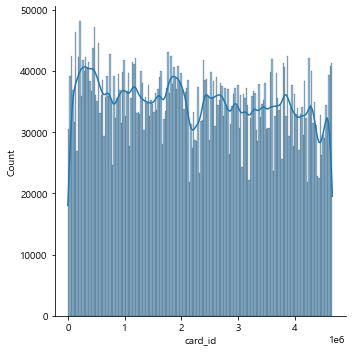

In [11]:
sns.displot(x = df['card_id'], kde=True)
plt.show()

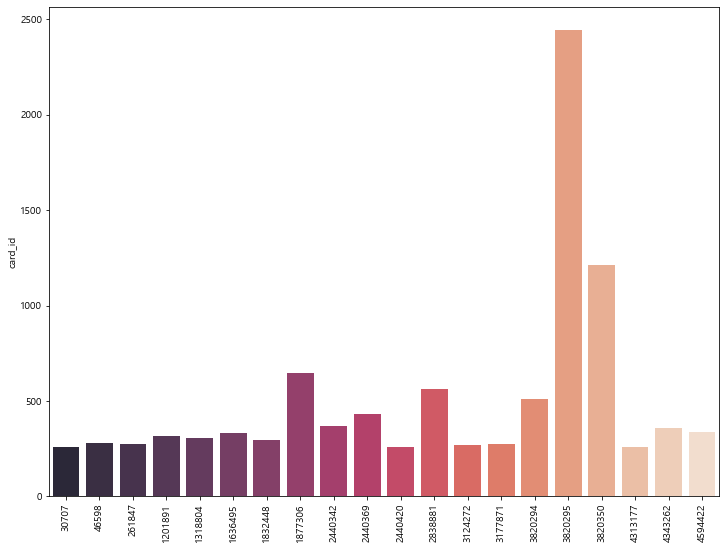

In [12]:
# 데이터 범주가 너무 넓어서 상위 20개 분포만 재확인
card_id = df['card_id'].value_counts()[:20].index
counts = df['card_id'].value_counts()[:20]

bar_plot = sns.barplot(x=card_id, y=counts, alpha=0.9, palette='rocket')
plt.xticks(rotation=90)
plt.show()

- 전체 6556613 개의 데이터 중 겹치지 않는 자료가 4663856개
- card_id는 한 고객이 여러개의 카드를 가질 가능성도 있고, 특정 카드를 사용할때 매출과 직접적으로 연관을 지을 수 있는 별도의 feature가 없음 
- 만약, 카드별 할인율이나 , 프모로션 제도 등에 대한 feature가 있다면 활용이 가능할 수 도 있음.
- 현재로선 예측 결과에 직접적인 영향을 주긴 어려운 feature일 것이라 판단됨.
- drop 하는 것이 바람직해 보인다.

### card_company 데이터 탐색

In [13]:
df['card_company'].unique()

array(['b', 'h', 'c', 'a', 'f', 'e', 'g', 'd'], dtype=object)

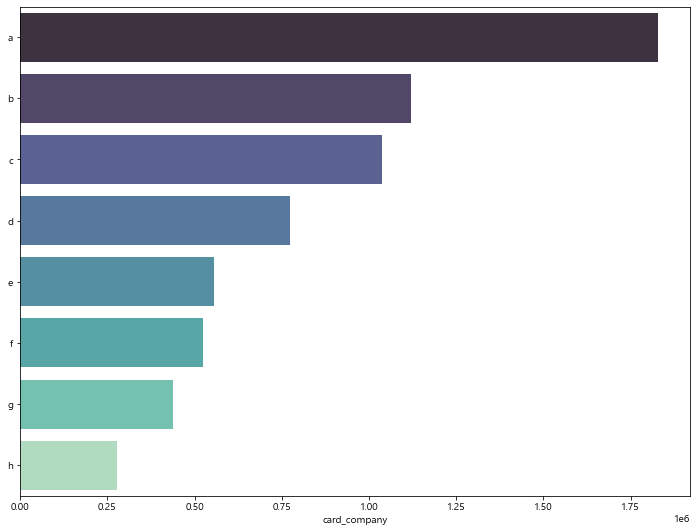

In [14]:
x = df['card_company'].value_counts().index
y = df['card_company'].value_counts()
sns.barplot(x=y, y=x, alpha=0.9, palette='mako');

- 비식별화된 카드회사 정보인데, 알파벳 순 = value_counts()가 일치 
    - 너무 짜여진 데이터 같음 => 모델이 잘못된 방식으로 데이터 인지할 가능성 우려
- 추가적으로, card_id 와 동일한 이유로 활용하기도 어려움
- drop 하는 것이 바람직해 보인다.

### transacted_date 데이터 탐색

In [15]:
print(df['transacted_date'])
pd.DataFrame(df['transacted_date']).isnull().sum() #결측치 확인

0          2016-06-01
1          2016-06-01
2          2016-06-01
3          2016-06-01
4          2016-06-02
              ...    
6556608    2019-02-28
6556609    2019-02-28
6556610    2019-02-28
6556611    2019-02-28
6556612    2019-02-28
Name: transacted_date, Length: 6556613, dtype: object


transacted_date    0
dtype: int64

- df의 시간 범위: 2016-06-01 ~ 2019-02-28
- 예측에 활용할 주요 feature
- 예측은 매장 별 3개월 총 매출이므로 **'일 단위'** 를 **'월 단위'** 데이터로 통합해야 함

### installment_term 데이터 탐색

In [16]:
df['installment_term'].value_counts(sort=True)

0     6327632
3      134709
2       42101
5       23751
6       10792
10       6241
4        4816
12       2699
60       1290
7         553
8         413
24        404
9         349
18        332
15        130
20        116
80         83
11         47
30         43
36         36
16         23
14         12
63          8
83          6
65          6
19          4
72          4
13          3
93          2
23          2
35          2
82          2
22          1
17          1
Name: installment_term, dtype: int64

In [17]:
#결측치 확인
pd.DataFrame(df['installment_term'].value_counts()).isnull().sum()

installment_term    0
dtype: int64

- 전체 6556613 개의 데이터 중 일시불인 경우가 6327632 로 대부분이다.
- 대부분이 일시불 값이므로 할부 T/F로 이진화 하여 feature로 사용하는 것이 더 유용할 것이다.

In [18]:
# 시각화 위해 데이터 이진화
df['installment_term2'] = (df['installment_term'] > 0).astype(int) # bool to int (True=1, False=0)
installment = df['installment_term2'].value_counts() 
installment = list(installment)

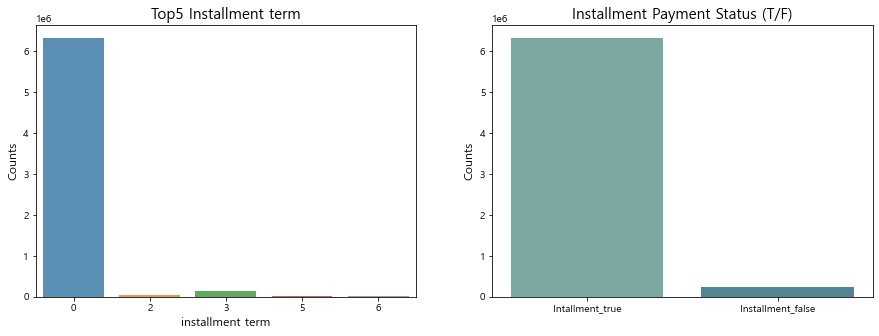

In [19]:
# canvas 크기 설정
plt.figure(figsize=(15,5))


# 그래프1
plt.subplot(121)

# 데이터 추출
count_installment_terms = df['installment_term'].value_counts(sort=True)
count_installment_terms = count_installment_terms[:5,]

# 그래프 1 시각화
sns.barplot(count_installment_terms.index, count_installment_terms.values, alpha=0.8)
plt.title('Top5 Installment term', fontsize = 15)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('installment term', fontsize=12)


# 그래프2
plt.subplot(122)
x = ['Intallment_true', 'Installment_false']
y = installment

# 그래프2 시각화
sns.barplot(x, y, alpha=0.8, palette='crest')
plt.ylabel('Counts', fontsize=12)
plt.title('Installment Payment Status (T/F)', fontsize=15)

plt.show()

### type_of_business 데이터 탐색

In [20]:
print((df['type_of_business'].value_counts())) #데이터 분포 확인
pd.DataFrame(df['type_of_business'].value_counts()).isnull().sum() #결측치 확인

한식 음식점업                     745905
두발 미용업                      178475
의복 소매업                      158234
기타 주점업                      102413
치킨 전문점                       89277
                             ...  
곡물 및 기타 식량작물 재배업               569
주방용품 및 가정용 유리, 요업 제품 소매업       551
배전반 및 전기 자동제어반 제조업             533
그 외 기타 생활용품 도매업                519
신선식품 및 단순 가공식품 도매업             231
Name: type_of_business, Length: 145, dtype: int64


type_of_business    0
dtype: int64

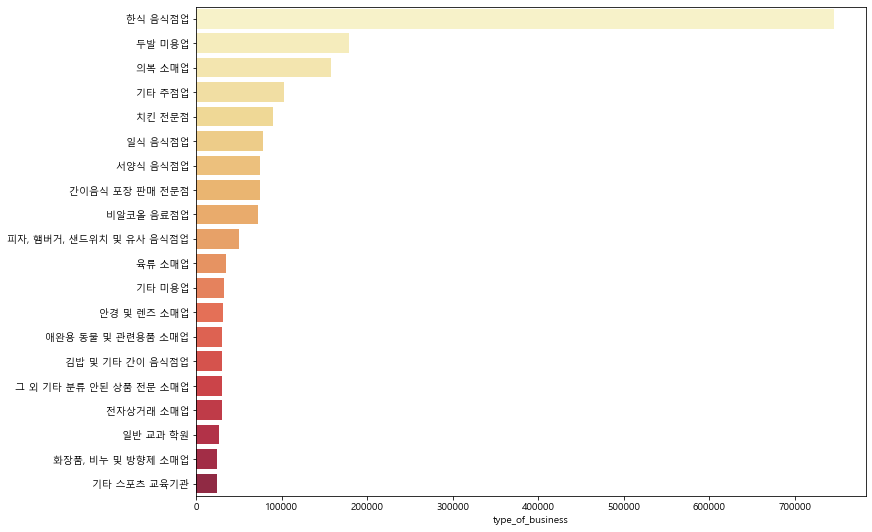

In [21]:
# 종류가 너무 많아 상위 20개만 확인
x = df['type_of_business'].value_counts()[:20].index
y = df['type_of_business'].value_counts()[:20]
sns.barplot(x=y, y=x, alpha=0.9, palette='YlOrRd');

- 범주형 변수
- 업종 종류가 너무 다양해서 type of business raw 데이터로는 예측을 위한 특징으로 사용하기는 어려울 것으로 판단된다.
- 그렇다고 dummy화 하기에는 수가 너무 많음
- store_id와는 명확하게 매칭이 되는 데이터 -> transacted_date 기준으로 분류하면 사용이 가능 할 듯.

### region 데이터 탐색

In [22]:
df['region'].value_counts().head()

경기 수원시    122029
충북 청주시    116766
경남 창원시    107147
경남 김해시    100673
경기 평택시     82138
Name: region, dtype: int64

In [23]:
pd.DataFrame(df['region']).describe()

,region
count,4513847
unique,180
top,경기 수원시
freq,122029


In [24]:
# 결측치 확인
pd.DataFrame(df['region']).isnull().sum()

region    2042766
dtype: int64

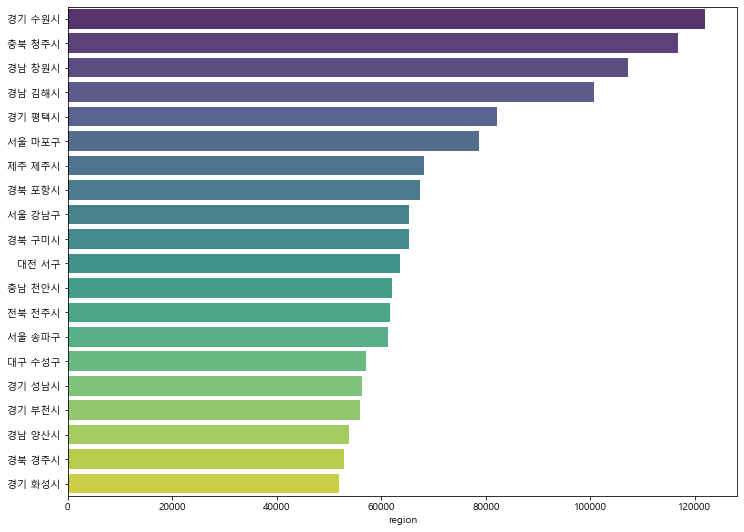

In [25]:
# 지역이 너무 많아 상위 20개만 확인
x = df['region'].value_counts()[:20].index
y = df['region'].value_counts()[:20]
sns.barplot(x=y, y=x, alpha=0.9, palette='viridis');

- 범주형 변수
- type of business 와 마찬가지로 지역의 unique value가 너무 많음 -> raw 데이터로는 예측을 위한 특징 으로 사용하기에 부적합
- region별 매출 특성을 파악 하는 것에는 사용이 가능할 듯.

### 변수 탐색 결론

- store_id : 각 상점을 구분지을 중요 feature. 변형없이 사용
- card_id, card_company : 매장 별 매출액 분석에 유의미 하지 않으므로 drop (도메인지식 기반 판단)
- intallment_term : 일시불(0)인 데이터가 압도적으로 많음 -> 일시불 / 할부 로 데이터 이원화 하는 것이 유용
- type_of_business , region : 범주형 데이터, 다만 range가 너무 커서 dummy할 수는 없음. 시간 & store 기준으로 데이터를 병합하면 매출 특성을 구분하는데 사용할 수 있을 것으로 예상됨
- transcade_time : 예측해야할 값은 '월 단위'. 특정 시간대의 매출 경향성이 전체 월 매출에 영향을 끼치지 않을 것이라 판단 
    - 추가로 transcade_date 와 중복되는 경향이 있어 배제
---
- transcade_date : '일' 단위 데이터 -> '월 단위' 로 변경 필요 : group by의 기준이 되는 데이터가 되어야 함 (분석의 key value)
    - standard_t(기준 월) 을 기준으로 매출 합계를 예측 해야 함
    
    - standard_t-2, standard_t-1, standard_t 3개의 데이터 기반 -> standard_t+1, standard_t+2, standard_t+3 을 예측 하는 방식
    
    - e.g) 2016년 1월 , 2016년 2월, 2016년 3월 매출 데이터 기반 -> 2016년 4월 매출, 2016년 5월 매출, 2016년 6월 매출을 예측하는 식으로 반복 학습 방식으로 3년치 데이터 기반으로 최종적으로 2019년 3월 ~ 5월 매출 예측 (중첩된 예측과 검증으로 예측력 상승을 기대)
    
    - 연도 & 월 로 하는 경우 데이터 구분이 명확하지 않을 가능성 있음. 특정 시점을 기준으로 Index 식으로 구분하는 것이 더 모델이 인지를 잘 할 것으로 예상

# Data Processing - Train data

## transcated_data - 파생변수 생성

### 년/월 추출 

In [26]:
# .str.split으로 년/월 추출

# year
df['transacted_year'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 0].astype(int)

# month
df['transacted_month'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 1].astype(int)
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,installment_term2,transacted_year,transacted_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14,0,2016,6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14,0,2016,6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00,0,2016,6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14,0,2016,6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00,0,2016,6


- transacted_date의 시작점이 2016년 6월 1일 이므로 transacted_year에서 2016을 빼고 'month'를 기준으로 데이터를 분류하는 index번호처럼 생성
계산 방식은 다음과 같다.

```python
standard_t = (연도-2016)*12 + '월'
```
- 2016년의 경우 6월 =6, 7월 =7
- 2017년의 경우 1월 = 12, 2월 = 24
- 위와 같이 각 연도별 월을 구분지을 수 있게 가공된다.

### 기준 시점이 될 std_mth (= standard_month) 생성

In [27]:
# 데이터 병합을 위해 시간 데이터를 standard_t 로 변경하고, 불필요한 컬럼은 drop
df['std_mth'] = (df['transacted_year'] - 2016) * 12 + df['transacted_month']
df.drop(['transacted_year', 'transacted_month', 'transacted_date', 'transacted_time'], axis = 1, inplace = True)

In [28]:
df['std_mth'].unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])

## 업종 특성, 지역, 할부 평균 - 파생변수 생성

### installment_term - 매장별 평균 할부 비율

- EDA에서 본 바와 같이 대부분이 일시불이므로 일시불 / 할부로 범주를 이원화 하여 사용 (전체 할부 개월 수 로 하기엔 너무 범위가 큼)
- 다만, 단순 할부 여부는 동일 매장에서 결제 건수가 여러건 발생 하므로 T/F로 입력할 수가 없다. -> 매장별 평균 할부개월 비율로 전처리

In [29]:
df['installment_term'] = (df['installment_term'] > 0).astype(int) # bool to int (True=1, False=0)
df['installment_term'].value_counts()

0    6327632
1     228981
Name: installment_term, dtype: int64

In [30]:
# 각 매장 기준으로 할부 기간의 평균 계산
installment_term_per_store = df.groupby(['store_id'])['installment_term'].mean()
installment_term_per_store.head()

store_id
0   0.04
1   0.00
2   0.08
4   0.00
5   0.08
Name: installment_term, dtype: float64

In [31]:
# 결측치 확인
pd.DataFrame(installment_term_per_store).isnull().sum()

installment_term    0
dtype: int64

### region - group by로 데이터 셋팅

- 범주형이지만, 종류가 너무 많아 dummy 하여 사용하기는 어려움 -> 활용을 위해 파생변수 생성 필요 (group by)
- 결측치가 2042766 개 존재함
- 결측치를 drop하기에는 너무 많은 데이터 -> 전처리를 통해 group by에 포함되도록 해야 함

In [32]:
# 결측치 전처리
df['region'].fillna('미분류', inplace = True)
df['region'].value_counts().head()

미분류       2042766
경기 수원시     122029
충북 청주시     116766
경남 창원시     107147
경남 김해시     100673
Name: region, dtype: int64

In [33]:
# 결측치 재확인
df['region'].value_counts().isnull().sum()

0

### type_of_business - 데이터 셋팅
- 범주형이지만, 종류가 너무 많아(145개) dummy 하여 사용하기는 어려움 -> 활용을 위해 파생변수 생성 필요 (group by)
- 결측치가 3952609 개 존재함
- 결측치를 drop하기에는 너무 많은 데이터 -> 전처리를 통해 group by에 포함되도록 해야 함

In [34]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
df['type_of_business'].fillna('미분류', inplace = True)
df['type_of_business'].value_counts().head()

미분류        3952609
한식 음식점업     745905
두발 미용업      178475
의복 소매업      158234
기타 주점업      102413
Name: type_of_business, dtype: int64

In [35]:
# 결과 재확인
df['type_of_business'].value_counts().isnull().sum()

0

### 불필요한 변수 제거
- card_id, card_company는 특징으로 사용하기에는 범주가 너무 세밀하고, 특징으로서 유의하지 않을 것이라 판단되므로 drop

In [36]:
df.drop(['card_id', 'card_company'], axis = 1, inplace = True)

### 중복 데이터 처리

In [37]:
# 'store_id', 'region', 'type_of_business', 'std_mth'를 기준으로 중복 제거
train_df = df.drop_duplicates(subset = ['store_id', 'region', 'type_of_business', 'std_mth'])[['store_id', 'region', 'type_of_business', 'std_mth']]
train_df.head()

,store_id,region,type_of_business,std_mth
0,0,미분류,기타 미용업,6
145,0,미분류,기타 미용업,7
323,0,미분류,기타 미용업,8
494,0,미분류,기타 미용업,9
654,0,미분류,기타 미용업,10


### 평균 할부율 입력 to train_df

In [38]:
train_df['평균할부율'] = train_df['store_id'].replace(installment_term_per_store.to_dict())

### std_mth(기준월)의 -1, -2, -3 시점에 대한 매장별 매출 / 지역별 매출 / 업종별 매출 파생변수 생성

- df1에서는 시점 t를, 다른 데이터에서는 시점 t+1 or t-1 을 붙여야 되는 상황
- t가 유니크 하다면, df2를 shift()해서 공백을 만든 뒤 concat을 하면 된다. (시계열 데이터에서 많이 사용)
- t가 유니크 하지 않은 경우는 새로운 변수( e.g: t_1)을 만들어서 merge한다.

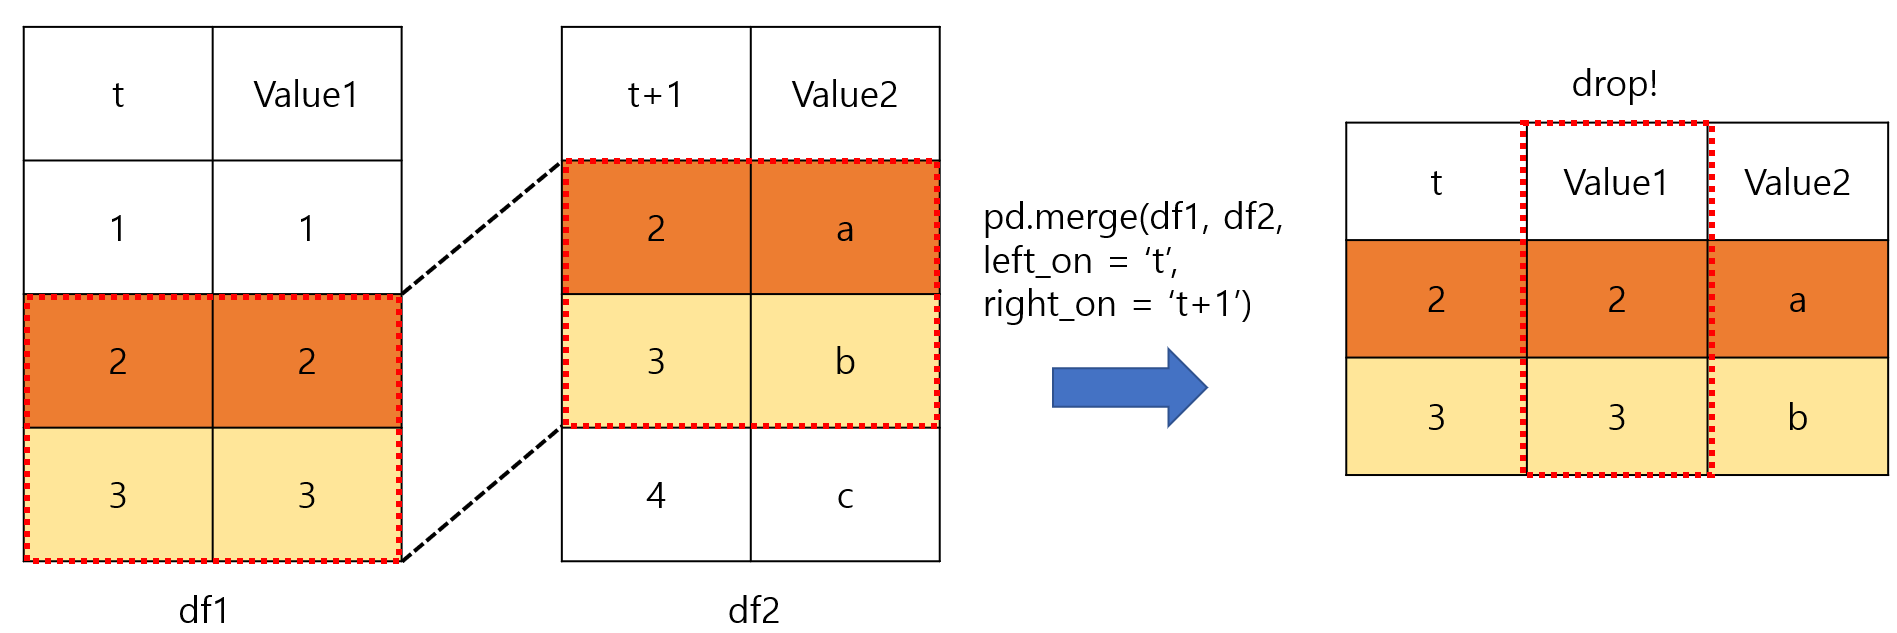

---
- 단, std_mth는 각 매장별로 값이 존재하고, 필요한 값은 기준 월(std_mth)을 중심으로 -1, -2, -3 개월의 매출 값이다.
- 이를 위해 for문을 사용하여 i = 1, 2, 3 일때 각각 t_{i} 값이 들어가는 변수를 만들어서 병합할 것이다.
- 중복 방지를 위해 병합한 변수명 변경 및 drop 작업도 함께 수행한다.

#### 각 시점별 매장의 월 매출 (파생변수)

##### 각 store당 월별 amount 계산

- standard_t (월): 6(2016년 6월) ~ 38 (2019년 2월)
- 즉, store_id가 0이라는 매장의 standard_t가 6일때의 매출 , 7일때의 매출... 38일때의 매출을 각각 입력

In [39]:
# store_id와 standard_t에 따른 amount 합계 계산: total_amt_per_mth_and_store
total_amt_per_mth_and_store = df.groupby(['store_id', 'std_mth'], as_index = False)['amount'].sum()
total_amt_per_mth_and_store.head()

,store_id,std_mth,amount
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43
3,0,9,897857.14
4,0,10,835428.57


- group by의 경우 지정한 조건에 해당하는 값이 없으면 건너뛴다.
- 각 지점별로 '모든 월' 에 대한 amount가 들어가야 하므로, 매장별 매출에서 값이 생략된 월들은 0으로 값을 넣어줘야 한다.
- 그렇지 않을 경우 다른 데이터와 merge 할 경우 에러 발생, 혹은 잘못된 값이 입력될 수 있다.

매장별로 결측된 월이 있는지 확인

In [40]:
total_amt_per_mth_and_store.groupby(['store_id'])['std_mth'].count()

store_id
0       33
1       33
2       33
4       33
5       33
        ..
2132    31
2133    32
2134    26
2135    31
2136    22
Name: std_mth, Length: 1967, dtype: int64

- 몇몇 store_id에서 누락된 값이 보인다.
- group by에서 생략된 값이 실제 매출이 발생했는데 단순 누락된 값인지, 매장 운영이 되지 않은 기간이어서 0인건지 확인이 어렵다.
- 이를 위해 pivot_table 활용
---
- 누락된 값이 연속적인 경우만 있다면 매출이 발생하지 않은 것으로 가정 하여 0으로 채운다.
    - e.g) 시작점은 2016년 6월이지만, 누락된 매장들은 시작점 보다 늦게 개점하여 누락된 경우


- 누락된 값이 불연속적이라면, 매출값이 누락된 것이라 가정하고 누락된 값의 '전/후' 값으로 채워넣는다.

In [41]:
# pivot_table로 nan값의 분포 형태 확인
check_nan_amount = pd.pivot_table(df, values = 'amount', index = 'store_id', columns = 'std_mth', aggfunc = 'sum')
check_nan_amount

std_mth,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,747000.00,1005000.00,871571.43,897857.14,835428.57,697000.00,761857.14,585642.86,794000.00,720257.14,685285.71,744428.57,682000.00,728285.71,749000.00,840857.14,600571.43,630857.14,812714.29,643142.86,685285.71,848428.57,636142.86,686428.57,707285.71,758714.29,679857.14,651857.14,739000.00,676000.00,874571.43,682857.14,515285.71
1,137214.29,163000.00,118142.86,90428.57,118071.43,111857.14,115571.43,129642.86,160214.29,168428.57,152571.43,107500.00,110357.14,132571.43,107642.86,131357.14,80142.86,110142.86,100714.29,109571.43,94214.29,108357.14,108857.14,80500.00,78285.71,100785.71,92142.86,63571.43,95000.00,80785.71,85285.71,148285.71,77428.57
2,260714.29,82857.14,131428.57,142857.14,109714.29,198571.43,160000.00,180714.29,154285.71,43571.43,201428.57,186428.57,120571.43,207142.86,190000.00,232857.14,266714.29,252857.14,238571.43,299714.29,312857.14,189714.29,283571.43,472857.14,354285.71,689285.71,457857.14,480714.29,510000.00,185428.57,340714.29,407857.14,496857.14
4,733428.57,768928.57,698428.57,936428.57,762714.29,859571.43,1069857.14,689142.86,1050142.86,970285.71,1085171.43,1035857.14,894142.86,1027285.71,1186857.14,972571.43,1060571.43,1189142.86,1010142.86,831571.43,651000.00,908000.00,792214.29,775428.57,881285.71,1050928.57,849285.71,698142.86,828428.57,883000.00,923857.14,944857.14,882285.71
5,342500.00,432714.29,263500.00,232142.86,211571.43,182085.71,147571.43,120957.14,186428.57,169000.00,312857.14,235342.86,475857.14,410914.29,297714.29,291428.57,396157.14,399285.71,441557.14,388428.57,316785.71,370142.86,297857.14,443857.14,563714.29,607071.43,482885.71,195000.00,324928.57,383300.00,399571.43,323000.00,215514.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,nan,nan,281142.86,783428.57,822000.00,941142.86,731142.86,684571.43,701000.00,742428.57,624614.29,566857.14,742857.14,865285.71,898428.57,787857.14,531857.14,1095000.00,1014071.43,580785.71,703857.14,909142.86,938428.57,670571.43,757857.14,753428.57,524142.86,637714.29,938571.43,729857.14,474285.71,571142.86,630428.57
2133,85000.00,367857.14,743571.43,494714.29,178571.43,124285.71,36285.71,31857.14,145114.29,313128.57,300685.71,384057.14,524342.86,425342.86,438257.14,493757.14,421214.29,646628.57,601171.43,433414.29,277342.86,308485.71,484071.43,626071.43,395700.00,421614.29,548942.86,310971.43,192700.00,84714.29,nan,84000.00,116285.71
2134,nan,nan,nan,nan,nan,393000.00,678214.29,459071.43,463428.57,446285.71,363571.43,580285.71,486857.14,503642.86,467785.71,431642.86,248714.29,355714.29,374142.86,313785.71,171857.14,245571.43,72357.14,216142.86,209785.71,140714.29,nan,nan,84428.57,60785.71,4285.71,209428.57,166000.00


- pivot table을 통해 보았을때, '월' 의 중간 중간 nan값이 발생하는 것으로 보아, 실제 매출은 발생하였으나 누락된 데이터 일 것이라 가정
- nan값을 바로 앞, 뒤 standard_t의 매출로 채워 넣는다.

In [42]:
# 발생한 nan값을 바로 앞/뒤의 값으로 채워넣는다.
# method = 'ffill', axis = 1 #전
# method = 'bfill', axis = 1 #후

total_amt_per_mth_and_store = check_nan_amount.fillna(method = 'ffill', axis = 1).fillna(method = 'bfill', axis = 1)
total_amt_per_mth_and_store.head(10)

std_mth,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,747000.00,1005000.00,871571.43,897857.14,835428.57,697000.00,761857.14,585642.86,794000.00,720257.14,685285.71,744428.57,682000.00,728285.71,749000.00,840857.14,600571.43,630857.14,812714.29,643142.86,685285.71,848428.57,636142.86,686428.57,707285.71,758714.29,679857.14,651857.14,739000.00,676000.00,874571.43,682857.14,515285.71
1,137214.29,163000.00,118142.86,90428.57,118071.43,111857.14,115571.43,129642.86,160214.29,168428.57,152571.43,107500.00,110357.14,132571.43,107642.86,131357.14,80142.86,110142.86,100714.29,109571.43,94214.29,108357.14,108857.14,80500.00,78285.71,100785.71,92142.86,63571.43,95000.00,80785.71,85285.71,148285.71,77428.57
2,260714.29,82857.14,131428.57,142857.14,109714.29,198571.43,160000.00,180714.29,154285.71,43571.43,201428.57,186428.57,120571.43,207142.86,190000.00,232857.14,266714.29,252857.14,238571.43,299714.29,312857.14,189714.29,283571.43,472857.14,354285.71,689285.71,457857.14,480714.29,510000.00,185428.57,340714.29,407857.14,496857.14
4,733428.57,768928.57,698428.57,936428.57,762714.29,859571.43,1069857.14,689142.86,1050142.86,970285.71,1085171.43,1035857.14,894142.86,1027285.71,1186857.14,972571.43,1060571.43,1189142.86,1010142.86,831571.43,651000.00,908000.00,792214.29,775428.57,881285.71,1050928.57,849285.71,698142.86,828428.57,883000.00,923857.14,944857.14,882285.71
5,342500.00,432714.29,263500.00,232142.86,211571.43,182085.71,147571.43,120957.14,186428.57,169000.00,312857.14,235342.86,475857.14,410914.29,297714.29,291428.57,396157.14,399285.71,441557.14,388428.57,316785.71,370142.86,297857.14,443857.14,563714.29,607071.43,482885.71,195000.00,324928.57,383300.00,399571.43,323000.00,215514.29
6,568857.14,568857.14,568857.14,1440142.86,1238857.14,1055428.57,926857.14,885642.86,800357.14,930714.29,855071.43,1029785.71,1071571.43,1037214.29,1054857.14,937857.14,1216285.71,1833571.43,2429500.00,2147714.29,2113357.14,2348714.29,1876857.14,1808357.14,1752285.71,1583785.71,1628785.71,2074071.43,1907642.86,2389142.86,2230285.71,2015500.00,2463857.14
7,107857.14,107857.14,107857.14,375642.86,323642.86,345000.00,291428.57,231614.29,271357.14,249857.14,131500.00,118642.86,53285.71,372285.71,183000.00,527857.14,218214.29,817714.29,750645.71,761571.43,636571.43,339857.14,1039357.14,265714.29,419542.86,462842.86,423128.57,320328.57,420028.57,314385.71,302414.29,136471.43,57971.43
8,192571.43,192571.43,192571.43,192571.43,192571.43,192571.43,735500.00,467857.14,475642.86,603500.00,1074642.86,1144571.43,1030928.57,1375571.43,1078928.57,984500.00,896785.71,514500.00,552214.29,618785.71,461714.29,744500.00,867071.43,1837428.57,1359857.14,1213542.86,1086000.00,1369557.14,1272071.43,1260557.14,1157257.14,1134671.43,1298328.57
9,107142.86,107142.86,107142.86,107142.86,107142.86,637142.86,603571.43,225428.57,287142.86,344428.57,352857.14,208571.43,178571.43,761714.29,535000.00,715714.29,672142.86,634285.71,333714.29,295428.57,628285.71,318571.43,1016857.14,638571.43,276571.43,340000.00,254285.71,926571.43,871428.57,692857.14,662857.14,370000.00,405714.29


- train_df와 병합을 위해 pivot_table 형태인 total_amt_per_mth_and_store 테이블을 stack() 함수를 사용해 동일한 형태의 DataFrame으로 변경

- stack() : column 과 row를 바꾸는 함수
- 위의 pivot_table 기준으로보면 store_id, std_mth, amount가 column이 되고, 기존 columns 별로 입력되있던 값이 row가 된다.

In [43]:
total_amt_per_mth_and_store = total_amt_per_mth_and_store.stack().reset_index() # index 번호 새로 부여

In [44]:
total_amt_per_mth_and_store

,store_id,std_mth,0
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43
3,0,9,897857.14
4,0,10,835428.57
...,...,...,...
64906,2136,34,2012214.29
64907,2136,35,2135428.57
64908,2136,36,2427428.57
64909,2136,37,1873642.86


In [45]:
# amount로 컬럼명 변경
total_amt_per_mth_and_store.rename({0:"amount"}, axis = 1, inplace = True)
total_amt_per_mth_and_store.head(3)

,store_id,std_mth,amount
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43


##### 매장별 월 매출 + train_df

In [46]:
# std_mth + i (i = 1, 2, 3) 시점의 부착
# train_df의 std_mth는 total_amt_per_mth_and_store의 std_mth-i와 부착되어야 하므로, total_amt_per_mth_and_store의 std_mth에 i를 더함

for i in range(1, 4): 
    # i값에 따른 새로운 변수 생성
    total_amt_per_mth_and_store['std_mth_{}'.format(i)] = total_amt_per_mth_and_store['std_mth'] + i
    
    # 두 테이블 데이터 결합
    # 두 table에 모두 std_mth가 존재하므로 drop
    train_df = pd.merge(train_df, total_amt_per_mth_and_store.drop('std_mth', axis = 1), left_on = ['store_id', 'std_mth'], right_on = ['store_id', 'std_mth_{}'.format(i)])
    
    # 변수명 변경: 다음 loop에서 merge할때 중복 column 때문에 _x, _y가 생기는 것 방지
    train_df.rename({"amount":"{}_before_amount".format(i)}, axis = 1, inplace = True)
    
    #필요없어진 변수 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    total_amt_per_mth_and_store.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00
1,0,미분류,기타 미용업,10,0.04,897857.14,871571.43,1005000.00
2,0,미분류,기타 미용업,11,0.04,835428.57,897857.14,871571.43
3,0,미분류,기타 미용업,12,0.04,697000.00,835428.57,897857.14
4,0,미분류,기타 미용업,13,0.04,761857.14,697000.00,835428.57


- std_mth의 시작점이 6 -> 9로 바뀐다. (for문이 적용되고 merge되면서 사라진 것)
- 6월의 amount는 3_before_amount에 입력되어 있다.
- 일괄적으로 +3이 된 것이기 때문에 ok
- std_mth 9(=16년 9월)를 기준으로 보았을때
    - 1_before_amount는 16년 8월, 2_before_amount는 16년 7월, 3_before_amount는 16년 6월을 의미한다.
    
    
    
- 전체적으로 본다면 2016년 6월에 대한 특징 데이터는 소실된다. 하지만 반대로 다른 시점에 특성을 구분할 수 있는 데이터가 늘어남  
---
- i값을 3으로 한 이유 :

    1) 예측해야 하는 값이 3개월 평균 이기 때문
    
    2) i가 클수록 유실되는 데이터량이 많아져서 최소화 하기 위해( 1)의 기간도 감안 )

#### 각 시점별 지역의 월 매출 (파생변수)

##### region(지역)  별 평균 매출 계산

In [47]:
#지역별 매장을 분류(dict) & 중복제거
store_to_region = df[['store_id', 'region']].drop_duplicates().set_index(['store_id'])['region'].to_dict() 

# store_id를 region으로 대체 -> 위에서 사용한 코드 동일하게 사용 가능
total_amt_per_mth_and_store['region'] = total_amt_per_mth_and_store['store_id'].replace(store_to_region)

# 지역별 평균 매출 계산
# total_amt_per_mth_and_store에 region이란 컬럼 추가 후 amt_mean_per_std_mth_and_region 테이블로 변경
amt_mean_per_std_mth_and_region = total_amt_per_mth_and_store.groupby(['region', 'std_mth'], as_index = False)['amount'].mean()

In [48]:
amt_mean_per_std_mth_and_region.head(3)

,region,std_mth,amount
0,강원 강릉시,6,623271.75
1,강원 강릉시,7,501311.43
2,강원 강릉시,8,508130.79


- 위에서 store_id의 누락치를 처리하는 과정에서 nan값을 모두 처리함
- 즉, store_id를 region으로 대체한 것이기 때문에, pivot_table & stack 등을 통한 결측치 제거는 하지 않아도 됨.

##### train_df + amt_mean_per_std_mth_and_region

In [49]:
# std_mth + i (i = 1, 2, 3)

for i in range(1, 4):
    amt_mean_per_std_mth_and_region['std_mth_{}'.format(i)] = amt_mean_per_std_mth_and_region['std_mth'] + i
    train_df = pd.merge(train_df, amt_mean_per_std_mth_and_region.drop('std_mth', axis = 1), left_on = ['region', 'std_mth'], right_on = ['region', 'std_mth_{}'.format(i)])
    train_df.rename({"amount":"{}_before_amount_of_region".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amt_mean_per_std_mth_and_region.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)    
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00,761987.42,756108.67,739654.07
1,1,미분류,미분류,9,0.00,118142.86,163000.00,137214.29,761987.42,756108.67,739654.07
2,2,미분류,미분류,9,0.08,131428.57,82857.14,260714.29,761987.42,756108.67,739654.07
3,5,미분류,의복 액세서리 및 모조 장신구 도매업,9,0.08,263500.00,432714.29,342500.00,761987.42,756108.67,739654.07
4,7,미분류,미분류,9,0.01,107857.14,107857.14,107857.14,761987.42,756108.67,739654.07


#### 각 시점별 업종의 월 매출 (파생변수)

##### type_of_business별 평균 매출 계산

In [50]:
##업종별 매장을 분류(dict) & 중복제거
store_to_type_of_business = df[['store_id', 'type_of_business']].drop_duplicates().set_index(['store_id'])['type_of_business'].to_dict()

# store_id를 type_of_business으로 대체 -> 위에서 사용한 코드 동일하게 사용 가능
total_amt_per_mth_and_store['type_of_business'] = total_amt_per_mth_and_store['store_id'].replace(store_to_type_of_business)

# 지역별 평균 매출 계산
amount_mean_per_mth_and_type_of_business = total_amt_per_mth_and_store.groupby(['type_of_business', 'std_mth'], as_index = False)['amount'].mean()

##### amount_mean_per_mth_and_type_of_business + train_df

In [51]:
# std_mth + i (i = 1, 2, 3)
# train_df의 std_mth는 total_amt_per_mth_and_store의 std_mth-i와 merge 해야하므로, total_amt_per_mth_and_store의 std_mth에 i를 더한다.

for i in range(1, 4):
    amount_mean_per_mth_and_type_of_business['std_mth_{}'.format(i)] = amount_mean_per_mth_and_type_of_business['std_mth'] + i
    train_df = pd.merge(train_df, amount_mean_per_mth_and_type_of_business.drop('std_mth', axis = 1), left_on = ['type_of_business', 'std_mth'], right_on = ['type_of_business', 'std_mth_{}'.format(i)])
    train_df.rename({"amount":"{}_before_amount_of_type_of_business".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amount_mean_per_mth_and_type_of_business.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)       
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00,761987.42,756108.67,739654.07,761025.00,804979.76,679950.00
1,792,미분류,기타 미용업,9,0.22,681142.86,880857.14,733714.29,761987.42,756108.67,739654.07,761025.00,804979.76,679950.00
2,23,경기 안양시,기타 미용업,9,0.05,879242.86,730857.14,845285.71,828831.71,588733.00,955973.29,761025.00,804979.76,679950.00
3,192,경기 화성시,기타 미용업,9,0.10,579000.00,523428.57,551142.86,1234460.01,1227920.91,1180455.31,761025.00,804979.76,679950.00
4,536,서울 광진구,기타 미용업,9,0.01,96285.71,79857.14,99857.14,3786819.95,3397972.56,3524074.62,761025.00,804979.76,679950.00


### label 부착하기 ( std_mth +1, std_mth+2, std_mth+3)

- label 은 기준월 (std_mth) 에서 각각 +1, +2, +3 인 시점에 대한 amount는 예측 모델을 통해 파악해야 하는 값이다.
- 이후 에는 model 학습을 위한 데이터 전처리가 들어가기 때문에, raw data인 현상황에서 +1, +2, +3 인 시점의 amount를 입력해 두는 것이 추후 작업에서 유용하다.

In [52]:
# 불필요한 컬럼 drop (중복 컬럼 방지)
total_amt_per_mth_and_store.drop(['region', 'type_of_business'], axis = 1, inplace = True)

# std_mth - i (i = 1, 2, 3)
for i in range(1, 4):
    total_amt_per_mth_and_store['std_mth_{}'.format(i)] = total_amt_per_mth_and_store['std_mth'] - i   
    train_df = pd.merge(train_df, total_amt_per_mth_and_store.drop('std_mth', axis = 1), left_on = ['store_id', 'std_mth'], right_on = ['store_id', 'std_mth_{}'.format(i)])
    train_df.rename({"amount": "Y_{}".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    total_amt_per_mth_and_store.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)      

In [53]:
train_df[['std_mth','Y_1','Y_2','Y_3']]

,std_mth,Y_1,Y_2,Y_3
0,9,835428.57,697000.00,761857.14
1,9,725142.86,653428.57,730071.43
2,9,741714.29,608857.14,844285.71
3,9,529000.00,545142.86,449714.29
4,9,87142.86,159928.57,124142.86
...,...,...,...,...
50226,31,13623585.71,10826500.00,12053585.71
50227,32,10826500.00,12053585.71,12916214.29
50228,33,12053585.71,12916214.29,13290000.00
50229,34,12916214.29,13290000.00,15355300.00


- for loop가 수행되면서 각각 i=1 일때, **total_amt_per_mth_and_store의 std_mth 기준으로** +1 인 시점의 amount 가 Y_1이 된다.
- i=2 일때는 std_mth 기준 +2 인 시점의 amount 가 Y_2이 되고, i=3 일때, std_mth 기준 +3 인 시점의 amount 가 Y_3이 된다.

In [54]:
# Y변수 (미래 3개월의 매출) 생성
train_df['Y'] = train_df['Y_1'] + train_df['Y_2'] + train_df['Y_3']

In [88]:
os.getcwd()

'E:\\OneDrive\\Jupyter\\포트폴리오\\[예측] 상점 신용카드 매출 예측하기'

In [89]:
train_df.to_csv('E:\\OneDrive\\Jupyter\\포트폴리오\\[예측] 상점 신용카드 매출 예측하기\\train_df.csv')

# Train data 살펴보기 - EDA & Data Processing

## feature & label 분리

In [55]:
train_df.columns

Index(['store_id', 'region', 'type_of_business', 'std_mth', '평균할부율', '1_before_amount', '2_before_amount', '3_before_amount', '1_before_amount_of_region', '2_before_amount_of_region', '3_before_amount_of_region', '1_before_amount_of_type_of_business', '2_before_amount_of_type_of_business', '3_before_amount_of_type_of_business', 'Y_1', 'Y_2', 'Y_3', 'Y'], dtype='object')

In [56]:
X = train_df.drop(['store_id', 'region', 'type_of_business', 'std_mth', 'Y_1', 'Y_2', 'Y_3', 'Y'], axis = 1)
Y = train_df['Y']

## 데이터 분할 및 구조 탐색

In [57]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

# 생성한 train 데이터 확인
Train_X.shape # 특징 대비 샘플이 많다. (특징 37673개,feature는 10개) -> 과적합 우려 없음

(37673, 10)

In [58]:
# label 데이터 확인
Train_Y.describe()

count       37673.00
mean      3405006.23
std       4845801.46
min       -174785.71
25%       1135857.14
50%       2208285.71
75%       4080285.71
max     172765924.57
Name: Y, dtype: float64

<AxesSubplot:xlabel='Y'>

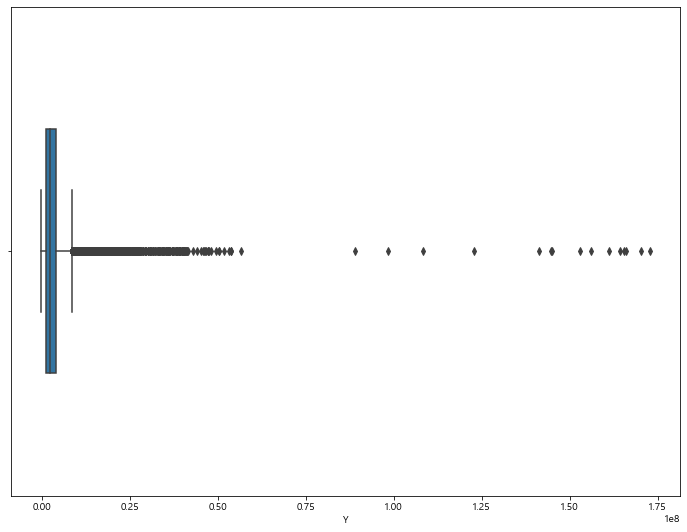

In [59]:
sns.boxplot(Train_Y, orient='v', width=0.5)

- 전체 매출의 평균은 3434534, 최소 매출은 0 이다.
- 최대 매출은 172765924 로 값의 차이가 매우 크다.

## 이상치 제거

- 값의 변동폭이 큰편이므로 이상치 제거가 필요 하다.

In [60]:
import numpy as np
def IQR_rule(val_list): # 한 특징에 포함된 값 (열 벡터)
    # IQR 계산    
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1
    
    # IQR rule을 결과를 bool list 계산 (True이면 이상치 X, False면 이상치 O)
    not_outlier_condition = (Q3 + 1.5 * IQR > val_list) & (Q1 - 1.5 * IQR < val_list)
    return not_outlier_condition

In [61]:
# 이상치가 아닌 label로만 구성된 Y_condition 라는 bool list 생성
Y_condition = IQR_rule(Train_Y)
Train_Y = Train_Y[Y_condition]
Train_X = Train_X[Y_condition]

<AxesSubplot:xlabel='Y'>

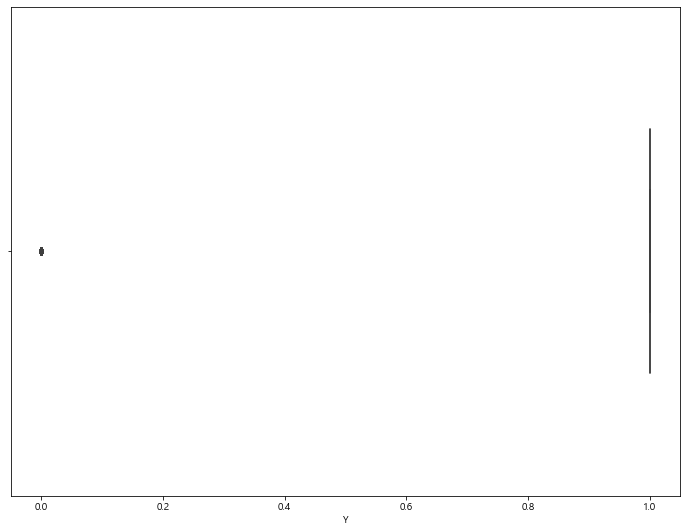

In [62]:
sns.boxplot(Y_condition, orient='v', width=0.5)

## 치우침 제거

In [63]:
# 데이터 편향 확인
Train_X.skew()

평균할부율                                 2.96
1_before_amount                       2.51
2_before_amount                       2.43
3_before_amount                       2.49
1_before_amount_of_region             3.29
2_before_amount_of_region             3.26
3_before_amount_of_region             3.21
1_before_amount_of_type_of_business   1.71
2_before_amount_of_type_of_business   1.87
3_before_amount_of_type_of_business   1.97
dtype: float64

- 모든 데이터가 1.5를 넘어 좌로 편향되어 있다.

In [64]:
# 치우침 제거
import numpy as np
biased_variables = Train_X.columns[Train_X.skew().abs() > 1.5] # 왜도의 절대값이 1.5 이상인 컬럼만 가져오기
Train_X[biased_variables] = Train_X[biased_variables] - Train_X[biased_variables].min() + 1 #가장 작은값이 1이 되도록
Train_X[biased_variables] = np.sqrt(Train_X[biased_variables])

In [65]:
# 데이터 편향 재확인

Train_X.skew()

평균할부율                                  2.76
1_before_amount                        0.74
2_before_amount                        0.73
3_before_amount                        0.74
1_before_amount_of_region              1.85
2_before_amount_of_region              1.83
3_before_amount_of_region              1.80
1_before_amount_of_type_of_business   -0.27
2_before_amount_of_type_of_business   -0.23
3_before_amount_of_type_of_business   -0.21
dtype: float64

## Data Scaling

In [66]:
# feature간 스케일 차이 확인
Train_X.max() - Train_X.min()

평균할부율                                    0.38
1_before_amount                       3694.92
2_before_amount                       3595.03
3_before_amount                       3595.03
1_before_amount_of_region             2588.24
2_before_amount_of_region             2588.24
3_before_amount_of_region             2588.24
1_before_amount_of_type_of_business   2271.41
2_before_amount_of_type_of_business   2581.72
3_before_amount_of_type_of_business   2614.04
dtype: float64

- 데이터 생성할때부터, 몇몇 데이터는 전체 지역의 평균, 혹은 전체 업종의 평균이기 때문에 평균 할부율 등의 값은 스케일이 매우 작을 수 밖에 없다. 
- 확실한 검증을 위해 확인차 실행해본 것 + 생성된 파생변수간에 스케일 차이가 있는지 확인하기 위해 실행

### MinMax 스케일링

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(Train_X)
s_Train_X = scaler.transform(Train_X)
s_Test_X = scaler.transform(Test_X)

# scaling결과 DataFrame으로 변경
Train_X = pd.DataFrame(s_Train_X, columns = Train_X.columns)
Test_X = pd.DataFrame(s_Test_X, columns = Train_X.columns)

# 불필요한 값 제거 (데이터가 많아 메모리 효율성을 위해 제거)
del s_Train_X, s_Test_X

# Modeling

## 모델 학습 

- 샘플 대비(약 3만개) 특징이 적고(10개), 특징의 타입이 전부 연속형으로 같다.
- 데이터가 '연속형'일때 사용하기 좋은 모델에는 KNN, 신경망등이 대표적이다.
- 다만, 신경망으로 쓰기엔 feature 수가 상대적으로 적어서 KNN을 선택
- 나머지는 앙상블 모델을 사용해 예측력을 높이고자 했다.

---

- 모델 1. kNN
- 모델 2. RandomForestRegressor
- 모델 3. LightGBM

- 특징 선택: 3 ~ 10개 (기준: f_regression)

In [68]:
# 모델링 모듈 불러오기
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from lightgbm import LGBMRegressor as LGB
from sklearn.feature_selection import *

In [69]:
#Cpu의 개수를 확인 : 작업할때 cpu 를 최대한 활용하기 위해 사양 check 
n_cpu=os.cpu_count()
print("The number of cpus: ",n_cpu)

The number of cpus:  6


In [70]:
# 일반적으로 보유한 cpu의 2배정도의 thread를 보유하고 있다
n_thread=n_cpu*2
print("Expected number of threads:",n_thread)

Expected number of threads: 12


In [71]:
# 파라미터 그리드 생성
param_grid = dict() 
# 입력: 모델 함수, 출력: 모델의 하이퍼 파라미터 그리드

# 모델별 파라미터 그리드 생성
param_grid_for_knn = ParameterGrid({"n_neighbors": [1, 3, 5, 7],
                           "metric":['euclidean', 'cosine']})

param_grid_for_RFR = ParameterGrid({"max_depth": [1, 2, 3, 4],
                           "n_estimators":[100, 200],
                                   "max_samples":[0.5, 0.6, 0.7, None]})

param_grid_for_LGB = ParameterGrid({"max_depth": [1, 2, 3, 4],
                                   "n_estimators":[100, 200],
                            "learning_rate": [0.05, 0.1, 0.15]})

# 모델 - 하이퍼 파라미터 그리드를 param_grid에 추가
param_grid[KNN] = param_grid_for_knn
param_grid[RFR] = param_grid_for_RFR
param_grid[LGB] = param_grid_for_LGB

In [72]:
param_grid

{sklearn.neighbors._regression.KNeighborsRegressor: <sklearn.model_selection._search.ParameterGrid at 0x1d7fa4899d0>,
 sklearn.ensemble._forest.RandomForestRegressor: <sklearn.model_selection._search.ParameterGrid at 0x1d7fa489940>,
 lightgbm.sklearn.LGBMRegressor: <sklearn.model_selection._search.ParameterGrid at 0x1d7fa4899a0>}

In [73]:
param_grid[KNN]

In [74]:
param_grid[RFR]

In [75]:
param_grid[LGB]

- Random Forest
    - feature수가 적어서 max_depth를 낮게 잡아 단순화함 (불필요한 과적합 방지)
    - 트리별 sample(max_samples)는 train_x의 표본이 충분해서 범위를 크게 잡지 않음
---
- LightGBM도 동일한 이유

In [76]:
# 출력을 위한 max_iter_num 계산
# 모델이 돌아가는 과정을 출력 (생략 가능)
max_iter_num = 0
for k in range(10, 2, -1):
    for M in param_grid.keys():
        for P in param_grid[M]:
            max_iter_num += 1

#평가지표 MAE 사용
from sklearn.metrics import mean_absolute_error as MAE

# MAE가 작을 수록 좋은 것이기 때문에 비교대상인 best_score을 최대한 크게 설정
best_score = 9999999999
iteration_num = 0 # iteration_num 0으로 초기화

for k in range(10, 2, -1): # 메모리 부담 해소를 위해, 1씩 감소시킴
    # SelectKBest로 모델에 가장 중요한 특성 자동 선택
    selector = SelectKBest(f_regression, k = k).fit(Train_X, Train_Y)
    # 선택된 컬럼을 selector.get_support() 함수로 Train_X의 컬럼으로 선택
    selected_features = Train_X.columns[selector.get_support()]
    
    # 선정된 feature을 각각 Train_X와 Test_X에 입력
    # loop에 따라 Train_X와 Test_X에 들어가는 feature들이 감소 -> 메모리 부담 완화
    Train_X = Train_X[selected_features]
    Test_X = Test_X[selected_features]
    
    
    for M in param_grid.keys():
        for P in param_grid[M]:
            # LightGBM에서 DataFrame이 잘 처리되지 않는 것을 방지하기 위해 .values를 사용
            
            # 모델학습
            model = M(**P).fit(Train_X.values, Train_Y.values)
            
            # 예측
            pred_Y = model.predict(Test_X.values)
            
            # 평가
            score = MAE(Test_Y.values, pred_Y)
            
            if score < best_score:
                best_score = score
                best_model = M
                best_paramter = P
                best_features = selected_features    
                
            iteration_num += 1
            
            # 진행상황 출력 : 몇번째 iter인지, 해당 순번의 best_score은 몇인지
            print("iter_num:{}/{}, score: {}, best_score: {}".format(iteration_num, max_iter_num, round(score, 2), round(best_score, 2)))

iter_num:1/512, score: 4098819.44, best_score: 4098819.44
iter_num:2/512, score: 3399445.36, best_score: 3399445.36
iter_num:3/512, score: 3890470.9, best_score: 3399445.36
iter_num:4/512, score: 4061793.26, best_score: 3399445.36
iter_num:5/512, score: 2111002.08, best_score: 2111002.08
iter_num:6/512, score: 1854831.56, best_score: 1854831.56
iter_num:7/512, score: 1767116.96, best_score: 1767116.96
iter_num:8/512, score: 1732777.37, best_score: 1732777.37
iter_num:9/512, score: 3152779.99, best_score: 1732777.37
iter_num:10/512, score: 3150001.39, best_score: 1732777.37
iter_num:11/512, score: 3152624.5, best_score: 1732777.37
iter_num:12/512, score: 3157880.88, best_score: 1732777.37
iter_num:13/512, score: 3154657.65, best_score: 1732777.37
iter_num:14/512, score: 3152385.96, best_score: 1732777.37
iter_num:15/512, score: 3147677.66, best_score: 1732777.37
iter_num:16/512, score: 3158188.02, best_score: 1732777.37
iter_num:17/512, score: 3856460.89, best_score: 1732777.37
iter_num

iter_num:140/512, score: 3160890.99, best_score: 1700359.29
iter_num:141/512, score: 3152383.87, best_score: 1700359.29
iter_num:142/512, score: 3154408.48, best_score: 1700359.29
iter_num:143/512, score: 3157212.8, best_score: 1700359.29
iter_num:144/512, score: 3157567.95, best_score: 1700359.29
iter_num:145/512, score: 3861111.37, best_score: 1700359.29
iter_num:146/512, score: 3864659.73, best_score: 1700359.29
iter_num:147/512, score: 3869631.45, best_score: 1700359.29
iter_num:148/512, score: 3866929.77, best_score: 1700359.29
iter_num:149/512, score: 3859119.87, best_score: 1700359.29
iter_num:150/512, score: 3864453.25, best_score: 1700359.29
iter_num:151/512, score: 3865299.39, best_score: 1700359.29
iter_num:152/512, score: 3869085.67, best_score: 1700359.29
iter_num:153/512, score: 4278817.53, best_score: 1700359.29
iter_num:154/512, score: 4258950.48, best_score: 1700359.29
iter_num:155/512, score: 4269922.42, best_score: 1700359.29
iter_num:156/512, score: 4273461.23, best

iter_num:277/512, score: 3869699.31, best_score: 1700359.29
iter_num:278/512, score: 3860387.6, best_score: 1700359.29
iter_num:279/512, score: 3871790.18, best_score: 1700359.29
iter_num:280/512, score: 3876943.3, best_score: 1700359.29
iter_num:281/512, score: 4283345.58, best_score: 1700359.29
iter_num:282/512, score: 4273497.32, best_score: 1700359.29
iter_num:283/512, score: 4280578.09, best_score: 1700359.29
iter_num:284/512, score: 4258829.28, best_score: 1700359.29
iter_num:285/512, score: 4262152.59, best_score: 1700359.29
iter_num:286/512, score: 4257305.46, best_score: 1700359.29
iter_num:287/512, score: 4259081.36, best_score: 1700359.29
iter_num:288/512, score: 4268759.81, best_score: 1700359.29
iter_num:289/512, score: 4542421.18, best_score: 1700359.29
iter_num:290/512, score: 4486035.52, best_score: 1700359.29
iter_num:291/512, score: 4544747.07, best_score: 1700359.29
iter_num:292/512, score: 4537082.38, best_score: 1700359.29
iter_num:293/512, score: 4503247.4, best_s

iter_num:414/512, score: 4270912.74, best_score: 1700359.29
iter_num:415/512, score: 4256161.66, best_score: 1700359.29
iter_num:416/512, score: 4258457.76, best_score: 1700359.29
iter_num:417/512, score: 4511149.44, best_score: 1700359.29
iter_num:418/512, score: 4521483.1, best_score: 1700359.29
iter_num:419/512, score: 4531992.75, best_score: 1700359.29
iter_num:420/512, score: 4519005.59, best_score: 1700359.29
iter_num:421/512, score: 4535800.79, best_score: 1700359.29
iter_num:422/512, score: 4497848.09, best_score: 1700359.29
iter_num:423/512, score: 4539390.12, best_score: 1700359.29
iter_num:424/512, score: 4535468.19, best_score: 1700359.29
iter_num:425/512, score: 4206033.49, best_score: 1700359.29
iter_num:426/512, score: 4551868.13, best_score: 1700359.29
iter_num:427/512, score: 4583064.26, best_score: 1700359.29
iter_num:428/512, score: 4618585.19, best_score: 1700359.29
iter_num:429/512, score: 4495382.45, best_score: 1700359.29
iter_num:430/512, score: 4522385.93, best

#### 최종 모델 학습

- 모델 선정과정에서 상요한 Train데이터는 X데이터를 split 한것이었으므로 다시 합쳐줄 필요가 있다.
- 하지만, split한 데이터들은 biase처리나 sacaling을 했지만, 예측에 사용할 X데이터는 전처리가 되어 있지 않다.
- 이를 위해 pipeline을 구축해서 X에도 동일한 전처리를 해준다.

In [77]:
def pipeline(X):
    # 치우침 처리
    X[biased_variables] = X[biased_variables] - X[biased_variables].min() + 1
    #Scaling
    X[biased_variables] = np.sqrt(X[biased_variables])        
    
    # DataFrame으로 변형
    X = pd.DataFrame(scaler.transform(X), columns = X.columns)
    
    # 선정된 feature만 X에 할당
    X = X[best_features]
    return X

# 최적의 값을 갖는 모델을 선정하여 fit
model = best_model(**best_paramter).fit(pipeline(X).values, Y)

## 적용 데이터 구성

In [78]:
# 예측해야할 값의 범위 : 2019-03-01 ~ 2019-05-31
# train데이터와 동일 방식으로 처리

submission_df['std_mth'] = (2019 - 2016) * 12 + 2

In [79]:
# region 변수와 type_of_business 변수 부착 
submission_df['region'] = submission_df['store_id'].replace(store_to_region)
submission_df['type_of_business'] = submission_df['store_id'].replace(store_to_type_of_business)

#### 특징 부착

In [80]:
submission_df['평균할부율'] = submission_df['store_id'].replace(installment_term_per_store.to_dict())
submission_df.head()

,store_id,amount,std_mth,region,type_of_business,평균할부율
0,0,0,38,미분류,기타 미용업,0.04
1,1,0,38,미분류,미분류,0.00
2,2,0,38,미분류,미분류,0.08
3,4,0,38,서울 종로구,미분류,0.00
4,5,0,38,미분류,의복 액세서리 및 모조 장신구 도매업,0.08


In [81]:
# 기존 submission_df 파일의 불필요한 컬럼 제거
submission_df.drop('amount', axis = 1, inplace = True)

In [82]:
# t - i (i = 1, 2, 3) 시점의 부착
# submission_df의 std_mth는 total_amt_per_mth_and_store의 std_mth-i와 병합되어야 하므로, total_amt_per_mth_and_store의 std_mth에 i를 더했다.

for i in range(1, 4):
    total_amt_per_mth_and_store['std_mth_{}'.format(i)] = total_amt_per_mth_and_store['std_mth'] + i    
    submission_df = pd.merge(submission_df, total_amt_per_mth_and_store.drop('std_mth', axis = 1), left_on = ['store_id', 'std_mth'], right_on = ['store_id', 'std_mth_{}'.format(i)])
    submission_df.rename({"amount":"{}_before_amount".format(i)}, axis = 1, inplace = True)
    submission_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    total_amt_per_mth_and_store.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    


In [83]:
# 지역 관련 변수 부착
for i in range(1, 4):
    amt_mean_per_std_mth_and_region['std_mth_{}'.format(i)] = amt_mean_per_std_mth_and_region['std_mth'] + i
    submission_df = pd.merge(submission_df, amt_mean_per_std_mth_and_region.drop('std_mth', axis = 1), left_on = ['region', 'std_mth'], right_on = ['region', 'std_mth_{}'.format(i)])
    submission_df.rename({"amount":"{}_before_amount_of_region".format(i)}, axis = 1, inplace = True)
    
    submission_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amt_mean_per_std_mth_and_region.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)    

In [84]:
# t - i (i = 1, 2, 3) 시점의 부착
# submission_df의 t는 total_amt_per_mth_and_store의 std_mth-i와 병합되어야 하므로, total_amt_per_mth_and_store의 std_mth에 i를 더했다.

for i in range(1, 4):
    amount_mean_per_mth_and_type_of_business['std_mth_{}'.format(i)] = amount_mean_per_mth_and_type_of_business['std_mth'] + i
    submission_df = pd.merge(submission_df, amount_mean_per_mth_and_type_of_business.drop('std_mth', axis = 1), left_on = ['type_of_business', 'std_mth'], right_on = ['type_of_business', 'std_mth_{}'.format(i)])
    submission_df.rename({"amount":"{}_before_amount_of_type_of_business".format(i)}, axis = 1, inplace = True)
    
    submission_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amount_mean_per_mth_and_type_of_business.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)       
    
submission_df.head()

,store_id,std_mth,region,type_of_business,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,38,미분류,기타 미용업,0.04,682857.14,874571.43,676000.00,946877.71,1000725.02,988619.51,585125.00,650055.95,558241.67
1,792,38,미분류,기타 미용업,0.22,743214.29,871071.43,973857.14,946877.71,1000725.02,988619.51,585125.00,650055.95,558241.67
2,1828,38,경기 용인시,기타 미용업,0.20,953000.00,816857.14,911957.14,1801050.57,2009935.83,1897274.57,585125.00,650055.95,558241.67
3,23,38,경기 안양시,기타 미용업,0.05,660857.14,999285.71,827571.43,784378.00,642183.20,678844.63,585125.00,650055.95,558241.67
4,192,38,경기 화성시,기타 미용업,0.10,467571.43,550571.43,399142.86,1209348.40,1125180.78,1049586.72,585125.00,650055.95,558241.67


In [116]:
submission_X = submission_df[X.columns]
submission_X = pipeline(submission_X)

pred_Y = model.predict(submission_X)

# 제출 양식과 맞추기 위해 pred_Y를 amount로 입력
result = pd.DataFrame({"store_id":submission_df['store_id'].values,"amount":pred_Y})

In [118]:
result = result.sort_values(by='store_id')

In [119]:
result

,store_id,amount
0,0,4714475.69
12,1,1527393.67
13,2,1564663.27
612,4,6729287.35
1187,5,4485424.49
...,...,...
609,2132,2883704.29
610,2133,1507944.90
1186,2134,2159169.39
611,2135,2164861.22


결과 제출용 파일 저장

In [120]:
result.to_csv('E:\\OneDrive\\Jupyter\\포트폴리오\\[예측] 상점 신용카드 매출 예측하기\\submission.csv', index=False)